In [22]:
!pip install yfinance ta seaborn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ta.volatility import BollingerBands
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle


In [23]:
import yfinance as yf
import pandas as pd

# Data download, change period and stock
Stock = input("Enter stock symbol (e.g., AAPL): ")
ticker = Stock

df = yf.download(ticker, period="1y", interval="1d")
df.dropna()
df.head()

Enter stock symbol (e.g., AAPL): NKE.BA


/tmp/ipython-input-23-3662180144.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="1y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NKE.BA,NKE.BA,NKE.BA,NKE.BA,NKE.BA
Date,,,,,
2024-07-11,8659.846680,8669.846503,8459.850221,8539.848804,81772
2024-07-12,8739.845703,8849.843761,8689.846586,8779.844997,75700
2024-07-15,7789.862793,8649.847646,7759.863321,8649.847646,65934
2024-07-16,7829.861816,7909.860405,7499.867640,7799.862346,53840
2024-07-17,7969.859375,8049.857963,7829.861845,7829.861845,50237


In [24]:
dfClose = df['Close']
dfClose = dfClose.transpose()
dfClose = dfClose.squeeze()

In [25]:
#Indicators


# Simple and Exponential Moving Average

df['SMA_10'] = SMAIndicator(close=dfClose, window=10).sma_indicator()
df['EMA_10'] = EMAIndicator(close=dfClose, window=10).ema_indicator()

# RSI
df['RSI'] = RSIIndicator(close=dfClose, window=14).rsi()

# MACD
macd = MACD(close=dfClose)
df['MACD'] = macd.macd_diff()

# Bollinger Band Width
bb = BollingerBands(close=dfClose)
df['BB_width'] = bb.bollinger_wband()

# Volume spike (as % change)
df['Volume_change'] = df['Volume'].pct_change()

n= int(input("Enter prediction period:"))

# Check if n is too large
if n >= len(df) - max(10, 14): # 10 and 14 are the largest window sizes for SMA and RSI
    print(f"Warning: Prediction period (n={n}) is too large for the available data after calculating indicators. Please enter a smaller value for n.")
    # You might want to exit here or handle this case differently depending on your needs
    # For now, we'll continue but the resulting df will be empty
else:
    # Target Variable: Rolling volatility over next n days (standard deviation of returns)
    df['Future_volatility'] = dfClose.pct_change().rolling(window=n).std().shift(-n)
    df = df.dropna()

df.tail()

Enter prediction period:5


Price,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI,MACD,BB_width,Volume_change,Future_volatility
Ticker,NKE.BA,NKE.BA,NKE.BA,NKE.BA,NKE.BA,,,,,,,
Date,,,,,,,,,,,,
2025-06-27,7210.0,7390.0,6580.0,6580.0,582321,6142.0,6289.731718,75.203083,76.768422,18.184920,2.722756,0.031498
2025-06-30,7160.0,7230.0,7020.0,7150.0,114765,6236.0,6447.962315,73.437416,113.547115,22.612285,-0.802918,0.029879
2025-07-01,7550.0,7580.0,7290.0,7290.0,71299,6392.0,6648.332803,77.813126,155.126982,28.711207,-0.378739,0.039922
2025-07-02,7910.0,7940.0,7580.0,7620.0,128175,6593.0,6877.726839,80.935137,195.268352,35.587204,0.797711,0.034091
2025-07-03,7840.0,7940.0,7760.0,7900.0,32368,6797.0,7052.685596,78.618576,204.517171,40.043548,-0.747470,0.036339


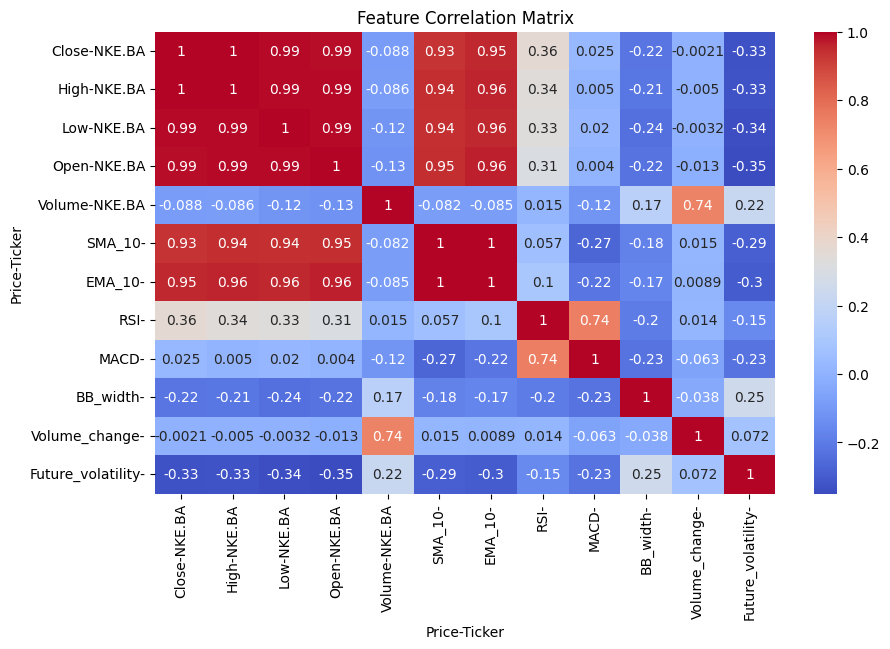

In [26]:
#Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


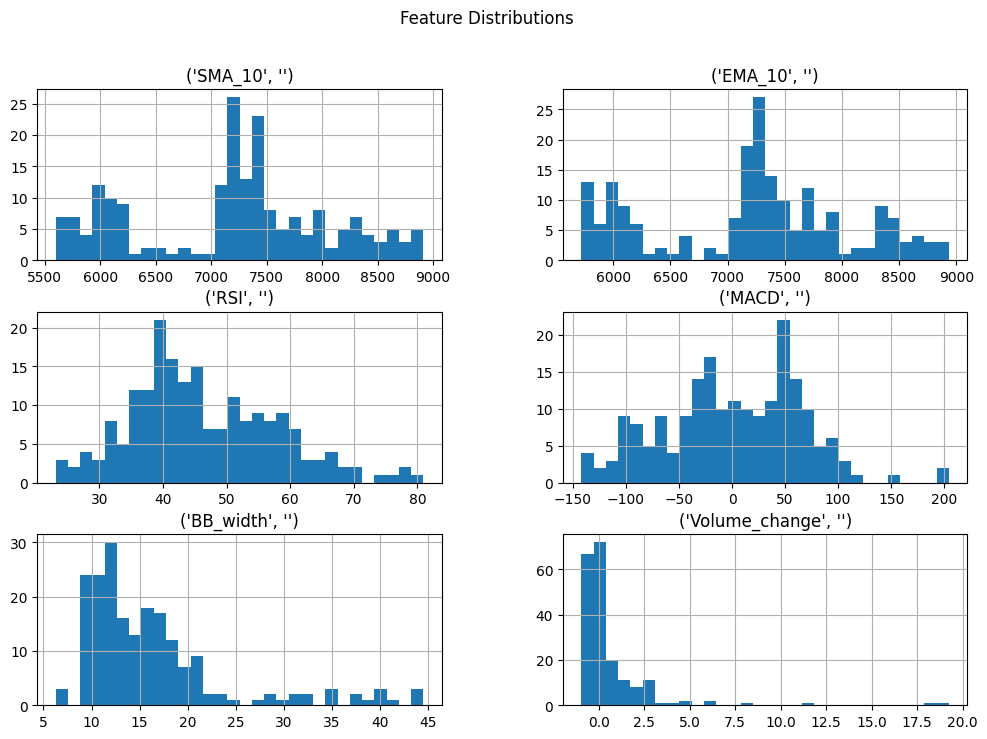

In [34]:
#Feature map
df[['SMA_10', 'EMA_10', 'RSI', 'MACD', 'BB_width', 'Volume_change']].hist(bins=30, figsize=(12, 8))
plt.suptitle("Feature Distributions")
plt.show()


In [28]:
#Model
features = ['SMA_10', 'EMA_10', 'RSI', 'MACD', 'BB_width', 'Volume_change']

# Check if df is empty before splitting
if not df.empty:
    X = df[features]
    y = df['Future_volatility']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f'Mean Squared Error on Test Set: {mse:.6f}')
else:
    print("DataFrame is empty. Cannot train the model.")

Mean Squared Error on Test Set: 0.000125


In [29]:
# Save the model using pickle
with open('volatility_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [30]:
import pickle

with open("volatility_model.pkl", "rb") as f:
    model = pickle.load(f)

In [31]:
features = ['SMA_10', 'EMA_10', 'RSI', 'MACD', 'BB_width', 'Volume_change']
latest_input = df[features].iloc[-1:]  # shape (1, n_features)


In [32]:
dfClose = df['Close']
dfClose = dfClose.transpose()
dfClose = dfClose.squeeze()
# (Recalculate the indicators just before prediction)
df['SMA_10'] = SMAIndicator(close=dfClose, window=10).sma_indicator()
# ... repeat for EMA_10, RSI, MACD, etc.
df.dropna(inplace=True)  # to remove rows with NaNs


In [33]:
predicted_volatility = model.predict(latest_input)[0]
print(f"Predicted {n} -day volatility for {ticker}: {predicted_volatility:.6f}")


Predicted 5 -day volatility for NKE.BA: 0.035557
